<a href="https://colab.research.google.com/github/veselm73/BP/blob/main/SDUEBA_011_custom_tspg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -r https://raw.githubusercontent.com/veselm73/BP/main/requirements_SDUEBA010.txt
!wget -q -O SDUEBA_utils.py https://raw.githubusercontent.com/veselm73/BP/main/SDUEBA_utils.py
!pip install umap-learn
!pip install gensim

  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
  Using cached scikit_learn-1.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached transformers-4.50.3-py3-none-any.whl.metadata (39 kB)
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.

In [2]:
# Dependencies
import os
import re
import string
import numpy as np
import pandas as pd
import scipy
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
from sklearn.preprocessing import normalize, LabelEncoder, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import torch
import gensim
import umap.umap_ as umap
import urllib.request

In [3]:
#SDUEBA Parameters:
"""
vector_space_dimension  ... dimention of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
"""
frac_of_dataset = 1
n_features = 30

#Embeddings parameters:
embedding_method = "word2vec"
vector_space_dimension = 150
descriptive_format = True
weighted_embeddings = False
use_bias = False

#Clustering parameters:
if use_bias:
    alpha_weight = 0.5
    bias_method = "perpendicular"         #"one_hot"/"perpendicular"

#Clustering parameters
# clustering_method = "agglomerative"       #"agglomerative"/"spherical_kmeans"/"tspg"/"hdbscan"
#One of these two has to be None, for kmeans dendogram_cut = None
n_clusters = 50
dendrogram_cut = None




max_depth = 2
test_size = 0.2
tree_accuracy_threshold = 0.95
target_column = 'readmit_binary'
target_value = 'Yes'

#Quality metric parameters
description_length_limit = 2
difference_limit = 0
subgroup_size_limit = 100

In [4]:
#Best feature selection
def create_shorter_sample(df, frac=None):
    df_sampled = df.sample(frac=frac, random_state=73)
    df_sampled = df_sampled.reset_index(drop=True)
    return df_sampled

def normalize_weights(weights):
    weights_array = np.array(weights)
    min_val = np.min(weights_array)
    max_val = np.max(weights_array)

    if max_val == min_val:
      return np.zeros_like(weights_array)

    normalized_weights = (weights_array - min_val) / (max_val - min_val)
    return normalized_weights

file_path = "https://kmlinux.fjfi.cvut.cz/~veselm73/diabetes_short_diag.csv"

df = create_shorter_sample(pd.read_csv(file_path), frac=frac_of_dataset)
df = df.drop(columns=['readmitted', 'readmit_30_days'])
df_encoded = df.copy()
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

imputer = SimpleImputer(strategy="most_frequent")
df_imputed = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)

X = df_imputed.drop(columns=["readmit_binary"])
y = df_imputed["readmit_binary"]

model = RandomForestClassifier(n_estimators=100, random_state=73)
model.fit(X, y)

feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight': normalize_weights(model.feature_importances_)})
feature_weights = pd.concat([feature_weights, pd.DataFrame({'Feature': [target_column], 'Weight': [1]})], ignore_index=True)
# feature_weights.head(30)


<ipython-input-4-c5f4ff287d41>:20: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = create_shorter_sample(pd.read_csv(file_path), frac=frac_of_dataset)


In [5]:
#Data augemntation
def create_quantile_categorical_feature(df, feature_name):

    if feature_name not in df.columns:
        print(f"Error: Feature '{feature_name}' not found in DataFrame.")
        return df

    num_quantiles = 5
    quantiles = np.linspace(0, 1, num_quantiles + 1)
    bins = df[feature_name].quantile(quantiles).tolist()
    bins[-1] = float('inf')

    bins = sorted(list(set(bins)))

    labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

    if len(bins) - 1 < 5:
        labels = labels[:len(bins) - 1]

    df[f'{feature_name}_category'] = pd.cut(df[feature_name], bins=bins, labels=labels, include_lowest=True, duplicates='drop')
    df = df.drop(columns=[feature_name])

    return df

top_features = feature_weights.sort_values(by='Weight', ascending=False).head(n_features)['Feature']
features_raw = df[top_features]
features_raw = features_raw.drop(columns=[target_column])

target_df = df[['readmit_binary']].copy()
target_df['readmit_binary'] = target_df['readmit_binary'].astype(str).replace({'True': 'Yes', 'False': 'No'})



for column in ['num_lab_procedures', 'num_medications', 'time_in_hospital', 'number_diagnoses', 'num_procedures', 'number_inpatient', 'number_outpatient', 'number_emergency']:
    features_raw = create_quantile_categorical_feature(features_raw, column)


print(len(features_raw))

101766


In [9]:
# Sentence creation
training_df = pd.merge(features_raw, target_df, left_index=True, right_index=True).astype(str)

class SentenceFormatter:
    def __init__(self, dataframe, descriptive_format=True):
        self.df = dataframe.copy()
        self.descriptive_format = descriptive_format

    def _prettify_column_names(self):
        return [' '.join(col.split('_')) for col in self.df.columns]

    def generate_sentences(self):
        sentences = []
        if self.descriptive_format:
            pretty_columns = self._prettify_column_names()
            for _, row in self.df.iterrows():
                sentence = []
                for col_name, val in zip(pretty_columns, row):
                    phrase = f"{col_name} is {val}"
                    sentence.extend(phrase.lower().split())
                sentences.append(sentence)
        else:
            for _, row in self.df.iterrows():
                sentence = []
                for val in row:
                    sentence.extend(str(val).lower().split())
                sentences.append(sentence)

        return sentences

formatter = SentenceFormatter(training_df, descriptive_format=True)
sentences = formatter.generate_sentences()
print(sentences[0])

['diag', '3', 'desc', 'is', 'asthma', 'extrinsic', 'primary', 'diag', 'desc', 'is', 'depressive', 'classified', 'diag', '2', 'desc', 'is', 'stated', 'mellitus', 'ii', 'mention', 'uncontrolled', 'age', 'is', '[80-90)', 'medical', 'specialty', 'is', 'nan', 'payer', 'code', 'is', 'nan', 'discharge', 'disposition', 'is', 'discharged', 'to', 'home', 'discharge', 'disposition', 'id', 'is', '1', 'insulin', 'is', 'no', 'race', 'is', 'caucasian', 'had', 'inpatient', 'days', 'is', 'true', 'gender', 'is', 'female', 'a1cresult', 'is', 'nan', 'admission', 'type', 'is', 'urgent', 'admission', 'type', 'id', 'is', '2', 'metformin', 'is', 'no', 'admission', 'source', 'is', 'emergency', 'room', 'admission', 'source', 'id', 'is', '7', 'change', 'is', 'no', 'glipizide', 'is', 'no', 'glyburide', 'is', 'steady', 'num', 'lab', 'procedures', 'category', 'is', 'high', 'num', 'medications', 'category', 'is', 'medium', 'time', 'in', 'hospital', 'category', 'is', 'very', 'high', 'number', 'diagnoses', 'category',

In [11]:
#Word2Vec/Bert training and clustering
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModel
def clear_cuda_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

class Word2VecModel:
    def __init__(self, sentences, vector_size=vector_space_dimension, window=15, min_count=1):
        self.model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count)

    def get_embedding(self, sentence, weighted_embeddings=False, feature_weights=None):
        word_embeddings = [self.model.wv[word] for word in sentence if word in self.model.wv]
        if not word_embeddings:
            return np.zeros(self.model.vector_size)

        if weighted_embeddings and feature_weights is not None:
            weights = np.array(feature_weights['Weight'].tolist())
            return np.average(word_embeddings, axis=0, weights=weights)
        return np.mean(word_embeddings, axis=0)

class BertEmbedder:
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2", device=None, batch_size=16):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device).half()
        self.batch_size = batch_size

    def get_embedding(self, sentences):
        if isinstance(sentences[0], list):
            sentences = [" ".join(sentence) for sentence in sentences]

        embeddings = []
        for i in range(0, len(sentences), self.batch_size):
            batch = sentences[i:i + self.batch_size]
            inputs = self.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=256).to(self.device)
            with torch.no_grad():
                outputs = self.model(**inputs)
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

        return np.vstack(embeddings)

class SentenceEmbedder:
    def __init__(self, method="word2vec", **kwargs):
        self.method = method.lower()

        if self.method == "word2vec":
            self.model = Word2VecModel(**kwargs)
        elif self.method == "bert":
            self.model = BertEmbedder(**kwargs)
        else:
            raise ValueError("Unsupported embedding method. Use 'word2vec' or 'bert'.")

    def generate_embeddings(self, sentences, normalize=False, weighted_embeddings=False, feature_weights=None):
        if self.method == "word2vec":
            embeddings = np.array([
                self.model.get_embedding(s, weighted_embeddings=weighted_embeddings, feature_weights=feature_weights)
                for s in sentences
            ])
        elif self.method == "bert":
            embeddings = self.model.get_embedding(sentences)
        else:
            raise ValueError("Unsupported embedding method.")

        if normalize:
            norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
            norms[norms == 0] = 1  # Avoid division by zero
            embeddings = embeddings / norms

        return embeddings

class BiasedEmbedder:
    def __init__(self, alpha=0.1, random_state=73, bias_method="one_hot", use_bias=True):
        self.use_bias = use_bias
        self.alpha = alpha
        self.random_state = random_state
        self.bias_method = bias_method.lower() if bias_method is not None else None

        if self.use_bias:
            self._validate_bias_method()

    def _validate_bias_method(self):
        if self.bias_method is None:
            return
        elif self.bias_method not in ["one_hot", "perpendicular"]:
            raise ValueError(f"Unsupported bias method: {self.bias_method}. Choose 'one_hot', 'perpendicular', or None.")

    def apply_bias(self, embeddings, targets):
        if not self.use_bias or self.bias_method is None:
            return embeddings

        if self.bias_method == "one_hot":
            return self._one_hot_bias_embeddings(embeddings, targets)
        elif self.bias_method == "perpendicular":
            return self._perpendicular_bias_embeddings(embeddings, targets)

    def _perpendicular_bias_embeddings(self, embeddings, targets):
        embeddings_biased = np.copy(embeddings)
        unique_classes, targets_encoded = np.unique(targets, return_inverse=True)
        np.random.seed(self.random_state)

        if len(unique_classes) > embeddings.shape[1]:
            raise ValueError("Number of unique classes exceeds embedding dimension, cannot create perpendicular biases.")

        bias_vectors = np.eye(len(unique_classes), embeddings.shape[1])

        for i, class_idx in enumerate(targets_encoded):
            embeddings_biased[i] += self.alpha * bias_vectors[class_idx]

        return embeddings_biased

    def _one_hot_bias_embeddings(self, embeddings, targets):
        unique_classes, targets_encoded = np.unique(targets, return_inverse=True)

        embeddings_extended = np.zeros((embeddings.shape[0], embeddings.shape[1] + len(unique_classes)))
        embeddings_extended[:, :embeddings.shape[1]] = embeddings

        for i, class_idx in enumerate(targets_encoded):
            embeddings_extended[i, embeddings.shape[1] + class_idx] = self.alpha

        return embeddings_extended



class ClusteringModel:
    def __init__(self, n_clusters=None, method="agglomerative", random_state=73,
                 dendrogram_cut=None, hdbscan_min_cluster_size=None):
        self.n_clusters = n_clusters
        self.method = method
        self.random_state = random_state
        self.dendrogram_cut = dendrogram_cut
        self.hdbscan_min_cluster_size = hdbscan_min_cluster_size
        self.linkage_matrix = None

    def fit_predict(self, embeddings):
        clustering_methods = {
            "spherical_kmeans": self._spherical_kmeans_clustering,
            "agglomerative": self._agglomerative_clustering,
            "tspg": self._tspg_clustering,
            "hdbscan": self._hdbscan_clustering
        }

        if self.method in clustering_methods:
            return clustering_methods[self.method](embeddings)

        raise ValueError(f"Unsupported clustering method: {self.method}")

    def _spherical_kmeans_clustering(self, X):
        np.random.seed(self.random_state)
        X = normalize(X, norm='l2', axis=1)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        cluster_centers = X[indices]

        for _ in range(200):
            similarities = X @ cluster_centers.T
            labels = np.argmax(similarities, axis=1)
            new_centroids = np.array([
                normalize(X[labels == j].mean(axis=0).reshape(1, -1))
                if np.any(labels == j) else cluster_centers[j]
                for j in range(self.n_clusters)
            ]).squeeze()

            if np.linalg.norm(new_centroids - cluster_centers) < 1e-4:
                break
            cluster_centers = new_centroids

        return labels

    def _tspg_clustering(self, embeddings):
        X = embeddings.tolist()
        if self.n_clusters is not None:
            labels, merge_order = tspg.tspg(X, self.n_clusters, distance="cos", num_tsp = int(np.log2(len(X)) * 2), dtype="vec")
            labels = np.array(labels) - 1
        else:
            raise ValueError(f"n_cluster parameter needed")

        return labels

    def _hdbscan_clustering(self, embeddings):
        distance_matrix = cosine_distances(embeddings).astype(np.float64)
        clusterer = hdbscan.HDBSCAN(min_cluster_size=self.hdbscan_min_cluster_size, metric='precomputed')

        labels = clusterer.fit_predict(distance_matrix)
        return labels

    def _agglomerative_clustering(self, embeddings):
        self.linkage_matrix = linkage(embeddings, method='average', metric='cosine')
        if self.dendrogram_cut:
            labels = fcluster(self.linkage_matrix, self.dendrogram_cut, criterion='distance') - 1
        elif self.n_clusters:
            labels = fcluster(self.linkage_matrix, self.n_clusters, criterion='maxclust') - 1
        else:
            labels = AgglomerativeClustering(n_clusters=self.n_clusters, metric='cosine', linkage='average').fit_predict(embeddings)
        return labels

    def plot_dendrogram(self, max_d=None, truncate_mode='level', p=30):
        if self.linkage_matrix is None:
            return

        plt.figure(figsize=(24, 6))
        dendrogram(self.linkage_matrix, truncate_mode=truncate_mode, p=p,
                   color_threshold=max_d, distance_sort='ascending', show_leaf_counts=True, no_labels=True)

        ylim = max_d * 1.1 if max_d else np.max(self.linkage_matrix[:, 2]) * 1.1
        plt.ylim(0, ylim)

        plt.title("Hierarchical Clustering Dendrogram", fontsize=16)
        plt.ylabel("Distance", fontsize=14)
        plt.tight_layout()
        plt.show()


if embedding_method == "word2vec":
    embedder = SentenceEmbedder(method="word2vec", sentences=sentences, vector_size=vector_space_dimension)
    sentence_embeddings = embedder.generate_embeddings(sentences, normalize=True)

elif embedding_method == "bert":
    embedder = SentenceEmbedder(method="bert", model_name="sentence-transformers/all-MiniLM-L6-v2")
    sentence_embeddings = embedder.generate_embeddings(sentences, normalize=True)

biased_embedder = BiasedEmbedder(use_bias=use_bias)
biased_embeddings = biased_embedder.apply_bias(embeddings=sentence_embeddings, targets=target_df[target_column])




# clustering_model = ClusteringModel(n_clusters=n_clusters, method=clustering_method, random_state=73, dendrogram_cut=dendrogram_cut, hdbscan_min_cluster_size=subgroup_size_limit )
# labels = clustering_model.fit_predict(biased_embeddings)

# clustering_model.plot_dendrogram()
print(biased_embeddings[:5])

In [25]:
#TSP Graph custom clustering
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.random_projection import GaussianRandomProjection
def fit_predict_tsp_graph_clustering(X, n_clusters=10, num_paths=2, window=5, metric='euclidean',normalize_input=False, depth=4, min_size=500, random_state=42):
    # Convert to float32 for memory efficiency
    X = np.array(X, dtype=np.float32)
    if normalize_input and metric == 'cosine':
        X = normalize(X, norm='l2')

    n = X.shape[0]
    rng = np.random.RandomState(random_state)
    edge_set = set()

    # Step 1: Build sparse TSP-based edge set
    for _ in range(num_paths):
        def recurse(indices, current_depth):
            if len(indices) <= min_size or current_depth >= depth:
                projection = GaussianRandomProjection(n_components=1, random_state=rng.randint(0, 1e9))
                X_proj = projection.fit_transform(X[indices]).flatten()
                sorted_idx = indices[np.argsort(X_proj)]
                for i in range(len(sorted_idx)):
                    for j in range(1, min(window + 1, len(sorted_idx) - i)):
                        a, b = sorted_idx[i], sorted_idx[i + j]
                        edge_set.add((min(a, b), max(a, b)))
                return
            projection = GaussianRandomProjection(n_components=1, random_state=rng.randint(0, 1e9))
            X_proj = projection.fit_transform(X[indices]).flatten()
            median = np.median(X_proj)
            left = indices[X_proj <= median]
            right = indices[X_proj > median]
            recurse(left, current_depth + 1)
            recurse(right, current_depth + 1)

        recurse(np.arange(n, dtype=np.uint32), 0)

    # Step 2: Vectorized distance computation
    a_idx = np.fromiter((i for i, _ in edge_set), dtype=np.uint32)
    b_idx = np.fromiter((j for _, j in edge_set), dtype=np.uint32)

    if metric == 'cosine':
        sims = np.sum(X[a_idx] * X[b_idx], axis=1)
        dists = 1.0 - sims
    else:  # Euclidean
        diffs = X[a_idx] - X[b_idx]
        dists = np.sqrt(np.sum(diffs**2, axis=1))

    edges = list(zip(dists, a_idx.tolist(), b_idx.tolist()))
    edges.sort()

    # Step 3: Union-Find structure
    parent = np.arange(n, dtype=np.uint32)

    def find(i):
        while parent[i] != i:
            parent[i] = parent[parent[i]]
            i = parent[i]
        return i

    def union(i, j):
        pi, pj = find(i), find(j)
        if pi != pj:
            parent[pi] = pj
            return True
        return False

    # Step 4: Merge using MST-style
    num_components = n
    for d, i, j in edges:
        if union(i, j):
            num_components -= 1
            if num_components == n_clusters:
                break

    # Step 5: Assign cluster labels
    label_map = {}
    labels = np.empty(n, dtype=np.uint32)
    next_label = 0
    for i in range(n):
        root = find(i)
        if root not in label_map:
            label_map[root] = next_label
            next_label += 1
        labels[i] = label_map[root]

    return labels

def reassign_small_clusters(X, labels, min_cluster_size=100, metric='cosine'):
    from sklearn.metrics import pairwise_distances_argmin


    unique, counts = np.unique(labels, return_counts=True)
    small_clusters = unique[counts < min_cluster_size]
    large_clusters = unique[counts >= min_cluster_size]

    if len(small_clusters) == 0:
        return labels

    centroids = {label: X[labels == label].mean(axis=0) for label in unique}

    new_labels = labels.copy()
    large_centroids = np.array([centroids[label] for label in large_clusters])

    for label in small_clusters:
        idxs = np.where(labels == label)[0]
        distances = pairwise_distances_argmin(X[idxs], large_centroids, metric=metric)
        for i, d in zip(idxs, distances):
            new_labels[i] = large_clusters[d]

    return new_labels

# import urllib.request
# url = "http://kmlinux.fjfi.cvut.cz/~veselm73/diabetes_bert_embeddings.npy"
# filename = "diabetes_embeddings.npy"

# urllib.request.urlretrieve(url, filename)

# data = np.load(filename)

from sklearn.decomposition import PCA
embeddings_reduced = PCA(n_components=60).fit_transform(biased_embeddings)


labels = fit_predict_tsp_graph_clustering(embeddings_reduced, n_clusters=n_clusters, num_paths=15, window=30, metric='cosine', normalize_input=True, min_size=150, depth=7)
# labels = reassign_small_clusters(biased_embeddings, labels, min_cluster_size=subgroup_size_limit, metric='cosine')


[0 0 0 0 0]


In [26]:
class DecisionTreeTrainer:
    def __init__(self, features_raw, labels, max_depth, subgroup_size_limit, test_size, random_state=73, print_acc=True):
        self.features_raw = features_raw
        self.labels = labels
        self.max_depth = max_depth
        self.subgroup_size_limit = subgroup_size_limit
        self.test_size = test_size
        self.random_state = random_state
        self.print_acc = print_acc

        self.encoder = OneHotEncoder()
        self.decision_trees = {}
        self.accuracies = {}
        self.small_clusters = {}

        self._prepare_data()
        self._train_trees()

    def _prepare_data(self):
        features_classify = self.features_raw.assign(cluster=self.labels)

        cluster_counts = features_classify['cluster'].value_counts()

        small_cluster_labels = cluster_counts[cluster_counts < self.subgroup_size_limit].index
        self.small_clusters = {
            label: features_classify[features_classify['cluster'] == label]
            for label in small_cluster_labels
        }

        features_classify = features_classify[~features_classify['cluster'].isin(small_cluster_labels)]

        X = features_classify.drop(columns=['cluster'])
        X_encoded = self.encoder.fit_transform(X)
        y = features_classify['cluster']

        self.X_df = pd.DataFrame(X_encoded.toarray(), columns=self.encoder.get_feature_names_out())

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_df, y, test_size=self.test_size, random_state=self.random_state, stratify=y)


    def _train_trees(self):
        for cluster in sorted(self.y_train.unique()):
            y_train_binary = (self.y_train == cluster).astype(int)
            y_test_binary = (self.y_test == cluster).astype(int)

            clf = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.subgroup_size_limit, random_state=self.random_state)
            clf.fit(self.X_train, y_train_binary)

            self.decision_trees[cluster] = clf

            y_pred = clf.predict(self.X_test)
            accuracy = accuracy_score(y_test_binary, y_pred)
            self.accuracies[cluster] = accuracy

            if self.print_acc:
                print(f"Accuracy for Cluster {cluster}: {accuracy:.4f}")
                print(classification_report(y_test_binary, y_pred))

    def get_trees(self):
        return self.decision_trees

    def get_accuracies(self):
        return self.accuracies

    def plot_decision_trees(self, cluster_index=None):
        if cluster_index is not None:
            if cluster_index in self.decision_trees:
                plt.figure(figsize=(12, 8))
                plot_tree(self.decision_trees[cluster_index], feature_names=self.X_df.columns, filled=True, rounded=True)
                plt.title(f"Decision Tree for Cluster {cluster_index}")
                plt.show()
            else:
                print(f"Cluster {cluster_index} not found.")
        else:
            for cluster, tree in self.decision_trees.items():
                plt.figure(figsize=(12, 8))
                plot_tree(tree, feature_names=self.X_df.columns, filled=True, rounded=True)
                plt.title(f"Decision Tree for Cluster {cluster}")
                plt.show()


tree_trainer = DecisionTreeTrainer(
    features_raw=features_raw,
    labels=labels,
    max_depth=max_depth,
    subgroup_size_limit=subgroup_size_limit,
    test_size=test_size,
    print_acc=False
)

In [27]:
# Subgroup creation and quality evaluation
def Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit):
    difference = abs(tp / (tp + fp) - (TP / (TP + FP)))
    if difference < difference_limit or description_length > description_length_limit or (tp + fp) < subgroup_size_limit:
        return np.NaN
    return difference / description_length

class ClusterRuleExtractor:
    def __init__(self, data_frame, target_df, cluster_labels, feature_names, decision_trees, trees_acc, tree_accuracy_threshold, small_clusters=None):
        self.data_frame = data_frame
        self.target_df = target_df
        self.cluster_labels = cluster_labels
        self.feature_names = feature_names
        self.decision_trees = decision_trees
        self.trees_acc = trees_acc
        self.tree_accuracy_threshold = tree_accuracy_threshold
        self.small_clusters = small_clusters if small_clusters is not None else {}

        self.target_column = target_df.columns[0]

        self.cluster_frequencies = {}
        self.cluster_percentages = {}
        self.rules_dict = {}
        self.unextractable_clusters = []
        self.WRAcc_dict = {}

        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}

        self._extract_rules_for_clusters()

    def _extract_rules_from_tree(self, tree, node=0, path=None, rule_dict=None):
        if path is None:
            path = []
        if rule_dict is None:
            rule_dict = defaultdict(list)

        left_child = tree.tree_.children_left[node]
        right_child = tree.tree_.children_right[node]
        threshold = tree.tree_.threshold[node]
        feature = tree.tree_.feature[node]
        value = tree.tree_.value[node]

        if left_child == -1 and right_child == -1:
            predicted_class = int(np.argmax(value[0]))
            rule_dict[predicted_class].append(path)
            return rule_dict

        feature_name = self.feature_names[feature]

        if left_child != -1:
            self._extract_rules_from_tree(tree, left_child, path + [f"{feature_name} <= {threshold:.2f}"], rule_dict,)

        if right_child != -1:
            self._extract_rules_from_tree(tree, right_child, path + [f"{feature_name} > {threshold:.2f}"], rule_dict,)

        return rule_dict

    def _extract_rules_for_clusters(self):
        N = len(self.target_df)
        class_counts_total = self.target_df[self.target_column].value_counts().to_dict()
        cluster_class_counts = defaultdict(lambda: defaultdict(int))

        for i, cluster in enumerate(self.cluster_labels):
            label = self.target_df[self.target_column].iloc[i]
            cluster_class_counts[cluster][label] += 1

        for cluster, class_counts in sorted(cluster_class_counts.items()):
            total_count = sum(class_counts.values())
            dominant_class = max(class_counts, key=class_counts.get)
            tp = class_counts[dominant_class]
            fp = total_count - tp

            self.cluster_frequencies[cluster] = total_count
            self.cluster_percentages[cluster] = {
                cls: round(count / total_count, 2) for cls, count in class_counts.items()
            }

            TP = class_counts_total[dominant_class]
            FP = N - TP
            self.tp_dict[cluster] = tp
            self.fp_dict[cluster] = fp
            self.TP_dict[cluster] = TP
            self.FP_dict[cluster] = FP

            self.WRAcc_dict[cluster] = ((total_count / N) * (tp / total_count - TP / N))

            if cluster in self.decision_trees:
                accuracy = self.trees_acc.get(cluster, 0)
                if accuracy < self.tree_accuracy_threshold:
                    self.unextractable_clusters.append(cluster)
                    self.rules_dict[cluster] = ["Accuracy below threshold"]
                else:
                    rule_sets = self._extract_rules_from_tree(self.decision_trees[cluster])
                    rules = []

                    for pred_class, paths in rule_sets.items():
                        if pred_class != 1:
                            continue
                        for path in paths:
                            rules.append(" AND ".join(path))

                    self.rules_dict[cluster] = rules
                    if len(rules) == 0:
                        self.rules_dict[cluster] = ["No rules extracted"]
                        self.unextractable_clusters.append(cluster)
            else:
                self.unextractable_clusters.append(cluster)
                self.rules_dict[cluster] = ["No decision tree for this cluster"]

        if hasattr(self, "small_clusters"):
            for small_cluster in self.small_clusters:
                if small_cluster not in self.unextractable_clusters:
                    self.unextractable_clusters.append(small_cluster)
                    self.rules_dict[small_cluster] = ["Too small for training (under subgroup_size_limit)"]

    def print_summary(self):
        print("Cluster Rule Summary:")
        for cluster in sorted(self.cluster_frequencies.keys()):
            support = self.cluster_frequencies[cluster]
            percentages_str = ", ".join(
                f"'{cls}': {perc}" for cls, perc in self.cluster_percentages[cluster].items()
            )
            WRAcc = round(self.WRAcc_dict[cluster], 6)
            print(f"Cluster {cluster}: support = {support}, {percentages_str}, WRAcc = {WRAcc}")

            rules = self.rules_dict.get(cluster, ["No rules extracted"])
            for rule in rules:
                print(f"  - {rule}")

        if self.unextractable_clusters:
            print("Unextractable Clusters:", self.unextractable_clusters)

clusters = ClusterRuleExtractor(
    data_frame=training_df,
    target_df=target_df,
    cluster_labels=labels,
    feature_names=list(tree_trainer.X_df.columns),
    decision_trees=tree_trainer.get_trees(),
    trees_acc=tree_trainer.get_accuracies(),
    tree_accuracy_threshold=tree_accuracy_threshold,
    small_clusters=tree_trainer.small_clusters
)


print("Clusters: ")
clusters.print_summary()

Clusters: 
Cluster Rule Summary:
Cluster 0: support = 101715, 'Yes': 0.46, 'No': 0.54, WRAcc = 9.3e-05
  - No rules extracted
Cluster 1: support = 1, 'No': 1.0, WRAcc = 5e-06
  - No decision tree for this cluster
Cluster 2: support = 1, 'Yes': 1.0, WRAcc = 5e-06
  - No decision tree for this cluster
Cluster 3: support = 1, 'No': 1.0, WRAcc = 5e-06
  - No decision tree for this cluster
Cluster 4: support = 1, 'Yes': 1.0, WRAcc = 5e-06
  - No decision tree for this cluster
Cluster 5: support = 1, 'No': 1.0, WRAcc = 5e-06
  - No decision tree for this cluster
Cluster 6: support = 1, 'Yes': 1.0, WRAcc = 5e-06
  - No decision tree for this cluster
Cluster 7: support = 1, 'Yes': 1.0, WRAcc = 5e-06
  - No decision tree for this cluster
Cluster 8: support = 1, 'Yes': 1.0, WRAcc = 5e-06
  - No decision tree for this cluster
Cluster 9: support = 1, 'No': 1.0, WRAcc = 5e-06
  - No decision tree for this cluster
Cluster 10: support = 1, 'Yes': 1.0, WRAcc = 5e-06
  - No decision tree for this clust

In [28]:
#Exclusive second condition merging
# Cluster 3: support = 480, 'edible': 1.0, WRAcc = 0.02848
#   - stalk-root_equal > 0.50 AND spore-print-color_brown <= 0.50
# Cluster 4: support = 384, 'edible': 1.0, WRAcc = 0.022784
#   - stalk-root_equal > 0.50 AND spore-print-color_brown > 0.50

class SubgroupCreator:
    def __init__(self, X_df, target_df, target_value, target_column, file_path):
        self.X_df = X_df
        self.target_df = target_df
        self.target_value = target_value
        self.target_column = target_column
        self.file_path = file_path
        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}
        self.WRAcc_dict = {}
        self.Quality_dict = {}
        self.subgroups = {}
        self.total_coverage = 0
        self.subgroup_descriptions = {}

    def evaluate_rule(self, rule_str, covered_indices_set):
        parts = rule_str.split(" AND ")
        mask = pd.Series(True, index=self.X_df.index)

        description = []

        for part in parts:
            feature, operator, value = part.rsplit(maxsplit=2)
            value = float(value)

            if ">" in operator:
                feature_name = feature.rsplit("_", 1)[0]
                category_value = feature.split("_")[-1]
                description.append(f"{feature_name} = '{category_value}'")
                mask &= self.X_df[feature] > 0.5

            elif "<=" in operator:
                feature_name = feature.rsplit("_", 1)[0]
                category_value = feature.split("_")[-1]
                description.append(f"{feature_name} ≠ '{category_value}'")
                mask &= self.X_df[feature] <= 0.5

        covered_indices = set(self.X_df[mask].index) - covered_indices_set
        covered_indices_set.update(covered_indices)
        covered_targets = self.target_df.loc[list(covered_indices)]

        tp = (covered_targets == self.target_value).sum().item()
        fp = (covered_targets != self.target_value).sum().item()
        TP = (self.target_df == self.target_value).sum().item()
        FP = (self.target_df != self.target_value).sum().item()

        WRAcc = ((tp + fp) / (TP + FP)) * ((tp / (tp + fp)) - (TP / (TP + FP)))

        return tp, fp, TP, FP, WRAcc, covered_indices, description

    def try_merge_rules(self, rules_list):
        from collections import defaultdict

        parsed_rules = []
        for rule in rules_list:
            if "No rules" in rule or "Accuracy below" in rule:
                continue
            conditions = sorted(rule.split(" AND "))
            parsed_rules.append((rule, conditions))

        condition_buckets = defaultdict(list)
        for original_rule, conditions in parsed_rules:
            for i in range(len(conditions)):
                key = tuple(conditions[:i] + conditions[i+1:])
                condition_buckets[key].append((original_rule, conditions))

        merged = set()
        final_rules = []

        for shared_conditions, group in condition_buckets.items():
            if len(group) == 2:
                (_, conds1), (_, conds2) = group
                differing = list(set(conds1) ^ set(conds2))
                if len(differing) == 2:
                    feat1 = differing[0].rsplit(" ", 2)[0]
                    feat2 = differing[1].rsplit(" ", 2)[0]
                    if feat1 == feat2:
                        merged_rule = " AND ".join(shared_conditions)
                        final_rules.append(merged_rule)
                        merged.update([group[0][0], group[1][0]])
            else:
                for rule, _ in group:
                    if rule not in merged:
                        final_rules.append(rule)

        untouched_rules = [r for r, _ in parsed_rules if r not in merged]
        final_rules.extend(untouched_rules)

        return list(set(final_rules))


    def evaluate_all_clusters(self, subgroups):
        with open(self.file_path, "w") as f:
            for cluster, rules_list in subgroups.rules_dict.items():
                if cluster not in subgroups.unextractable_clusters:
                    rules_list = self.try_merge_rules(rules_list)
                    covered_indices_set = set()

                    for idx, rule_str in enumerate(rules_list):
                        if "No rules extracted" in rule_str or "Accuracy below threshold" in rule_str:
                            continue

                        letter_index = string.ascii_lowercase[idx]
                        subgroup_label = f"{cluster}.{letter_index}"

                        tp, fp, TP, FP, WRAcc, covered_indices, description = self.evaluate_rule(rule_str, covered_indices_set)

                        self.tp_dict[subgroup_label] = tp
                        self.fp_dict[subgroup_label] = fp
                        self.TP_dict[subgroup_label] = TP
                        self.FP_dict[subgroup_label] = FP
                        self.WRAcc_dict[subgroup_label] = WRAcc
                        self.subgroups[subgroup_label] = covered_indices
                        self.total_coverage += tp + fp

                        description_str = ", ".join(str(item) for item in description)
                        self.Quality_dict[subgroup_label] = Quality_metric(
                            tp=tp,
                            fp=fp,
                            TP=TP,
                            FP=FP,
                            description_length=len(description),
                            description_length_limit=description_length_limit,
                            difference_limit=difference_limit,
                            subgroup_size_limit=subgroup_size_limit,
                        )
                        self.subgroup_descriptions[subgroup_label] = description_str

                        f.write(
                            f"Description: [{description_str}], Target: {target_column} = '{self.target_value}' ; "
                            f"QuMe = {float(self.Quality_dict[subgroup_label]) if self.Quality_dict[subgroup_label] is not None else 0:.8f} ; "
                            f"WRAcc = {float(WRAcc) if WRAcc is not None else 0:.8f} ; "
                            f"tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                        )
            f.write(f"Total coverage: {self.total_coverage / len(self.target_df)}\n")


evaluator = SubgroupCreator(tree_trainer.X_df, target_df, target_value=target_value, target_column=target_column, file_path="results_SDUEBA.txt")
evaluator.evaluate_all_clusters(clusters)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


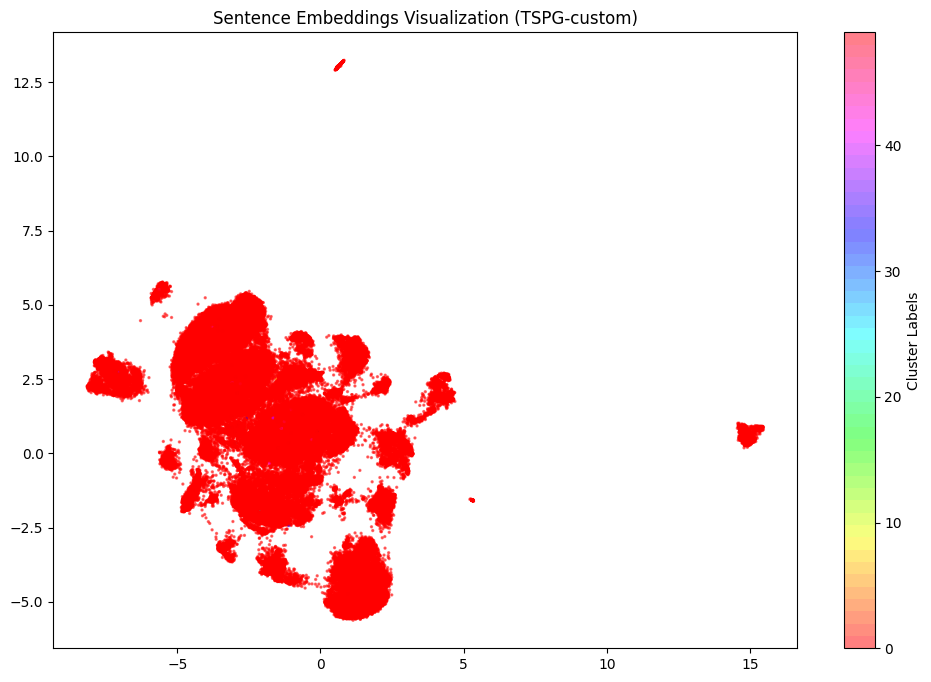

In [29]:
# Clusters visualization
def plot_sentence_embeddings(embeddings, cluster_labels, clustering_method=None):
    plt.figure(figsize=(12, 8))

    reducer = umap.UMAP(n_components=2, random_state=73, n_neighbors=200, min_dist=0.1, metric='cosine')
    embeddings_2d = reducer.fit_transform(np.array(embeddings))

    cluster_labels = np.array(cluster_labels)

    cmap = plt.get_cmap('hsv', len(set(cluster_labels)))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap=cmap, alpha=0.5, s=2)

    plt.colorbar(scatter, label='Cluster Labels')
    plt.title(f"Sentence Embeddings Visualization ({clustering_method})")
    plt.show()

plot_sentence_embeddings(biased_embeddings, cluster_labels=labels, clustering_method='TSPG-custom')

In [ ]:
!pip install subgroups

In [ ]:
%%time
run_this = True

if run_this:
    from subgroups.algorithms import BSD
    from subgroups.quality_measures import WRAcc
    from subgroups.quality_measures import WRAccOptimisticEstimate1

    dataset = pd.concat([features_raw, target_df], axis=1).astype(str)
    target = (target_column, target_value)
    #num_subgroups=50!!!!
    bsd_model = BSD(min_support=0, quality_measure=WRAcc(), optimistic_estimate = WRAccOptimisticEstimate1(), num_subgroups=50, max_depth=2, write_results_in_file = True, file_path = "./results_BSD.txt" )
    bsd_model.fit(dataset, target)


In [ ]:
def parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit):
    output_file = "results_BSD_.txt"

    with open(file_path, 'r') as file, open(output_file, 'w') as output:
        for line in file:
            match = re.search(r"(Description: \[.*?\]), Target: (.*?) ; Quality Measure WRAcc = ([\d.-]+) ; tp = (\d+) ; fp = (\d+) ; TP = (\d+) ; FP = (\d+)", line)

            if match:
                description = match.group(1)
                target = match.group(2)
                WRAcc = float(match.group(3))
                tp = int(match.group(4))
                fp = int(match.group(5))
                TP = int(match.group(6))
                FP = int(match.group(7))

                description_text = description[13:-1]
                description_length = description_text.count(',') + 1 if description_text else 1

                quality_score = Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit)

                output_line = f"{description}, Target: {target} ; QuMe = {quality_score:.8f} ; WRAcc = {WRAcc:.8f} ; tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                output.write(output_line)

file_path = "results_BSD.txt"
parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit)

In [ ]:
# Overlap ratio
def compute_coverage(filename, quality_measure, k, dataset, print_subgroups=False):
    with open(filename, 'r') as file:
        lines = file.readlines()

    subgroups = []
    instance_coverage = {}

    for line in lines:
        match = re.search(rf"{quality_measure}\s*=\s*([-+]?\d*\.?\d+)\s*;.*tp\s*=\s*(\d+)\s*;\s*fp\s*=\s*(\d+)", line)
        if match:
            quality = float(match.group(1))
            tp = int(match.group(2))
            fp = int(match.group(3))

            desc_match = re.search(r"Description: \[(.*?)\]", line)
            if desc_match:
                description = desc_match.group(1).split(", ")
            else:
                description = []

            mask = pd.Series(True, index=dataset.index)
            for condition in description:
                try:
                    feature, value = condition.split(" = ")
                    value = value.strip("'")

                    if feature not in dataset.columns:
                        continue

                    mask &= dataset[feature] == value
                except ValueError:
                    continue

            covered_instances = set(dataset[mask].index)

            for instance in covered_instances:
                instance_coverage[instance] = instance_coverage.get(instance, 0) + 1

            subgroups.append((quality, covered_instances, description, line.strip()))

    subgroups.sort(reverse=True, key=lambda x: x[0])
    top_k_subgroups = subgroups[:k]

    covered_instances = set()
    filtered_instance_coverage = {}

    for _, instance_ids, _, _ in top_k_subgroups:
        covered_instances.update(instance_ids)
        for instance in instance_ids:
            filtered_instance_coverage[instance] = filtered_instance_coverage.get(instance, 0) + 1

    coverage = len(covered_instances) / len(dataset) if len(dataset) else 0
    overlapping_instances = sum(1 for count in filtered_instance_coverage.values() if count > 1)
    overlap_ratio = overlapping_instances / len(covered_instances) if covered_instances else 0

    if print_subgroups:
        print("Top-k subgroups:")
        for _, _, _, subgroup in top_k_subgroups:
            print(subgroup)

    results = {
        "coverage": coverage,
        "overlap_ratio": overlap_ratio
    }

    return results


print("SDUEBA model:")
results_SDUEBA = compute_coverage('results_SDUEBA.txt', 'QuMe', n_clusters, features_raw, True)
print(f"Coverage: {results_SDUEBA['coverage']}, Overlap Ratio: {results_SDUEBA['overlap_ratio']}")

print("BSD model:")
results_BSD = compute_coverage('results_BSD_.txt', 'QuMe', n_clusters, features_raw, True)
print(f"Coverage: {results_BSD['coverage']}, Overlap Ratio: {results_BSD['overlap_ratio']}")

In [ ]:
results = {
    "SDUEBA": results_SDUEBA,
    "BSD": results_BSD
}
print(results)